# Craigslist Rental-housing Analysis
# *Data Science Mini-tutorial*

In this tutorial, I'd like to demonstrate an application of data science to analyzing the current rental housing market in College Park through the craiglist's data. In doing so, we'll make use of several key tools in any data scientists toolkit, with varying degrees of depth: <br> <br>
1) Beautiful Soup 4  <br>
2) pandas  <br>
3) numpy <br>
4) sqlalchemy/SQLite <br>
4) seaborn <br>
5) Folium <br>
6) Scikit-Learn <br>
<br>
Part 1) We'll start by  using *Beautiful Soup* to make a first pass and scrape the data off of craigslist's website for all rental postings withing 5 miles of College Park. We'll store the data in a *pandas* dataframe. We'll do a second pass and gather additional data from the links for the listings themselves. We'll use the longitude/latitude to compute two entirely new pieces of data: distance to the University of Maryland and distance to the nearest metro station. 

Part 2) Next, we'll make use of python's *sqlalchemy* package, which allows us to create a database and store our datafram as a table in that database. We can then query this database to retrieve our data, instead of repeating the scraping work we did above.

Part 3) We'll do some boring clean-up work, where we make our data a bit prettier as well as make sure it is in a suitable format for analysis.

Part 4) Analysis! Using our newfound data, we'll use *seaborn* to make plots of the distributions of housing prices, and use *Folium* to make a geospatial heatmap of the price/sqft of rentals.

Part 5) Finally, we'll use *Scikit-learn* and train a k-nearest neighbors regression model on half of our dataset, and then try to predict the prices of a few of the rentals in the other half of the dataset. <br>

Without further ado, let's get to it!






# Part 1: Data scraping and preparation

### Let's do some scraping

In [211]:
#Import all the relevant packages
import requests
from bs4 import BeautifulSoup
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np
import seaborn as sns
import folium 
from folium.plugins import HeatMap

In [1]:
#Get link for desired area. We'll take renting apartments and housing, 5 mile radius of College Park 20740
link = 'https://washingtondc.craigslist.org/search/mld/apa?search_distance=5&postal=20740&availabilityMode=0&sale_date=all+dates'
def makeSoup(link):
    r = requests.get(link)
    soup = BeautifulSoup(r.content, 'lxml');
    return(soup)
#makeSoup(link)

Looking at the source code after searching for all apts/housing for rent within 5 miles of CP, we see that every entry on the MAP starts with <li class="result-row" data-pid="675xxxxxxx".



In [213]:
# LETS GET SOME ATTRIBUTES
# Using a BeautifulSoup object, we extract in our first pass the relevant information on the posting that can be obtained 
# before visiting the link.
def getHouses(soup):
    sum_Unlabeled = 0 
    r_matrix = []
    for row in soup.find_all(class_="result-row"):
        #Try catch Nonetype object error (can't call .text)
        try:
            pID = row.get('data-pid')
            rtitle = row.find(class_="result-title hdrlnk") #Grabs post title + href
            rtitle_txt = rtitle.text
            price = row.find(class_='result-price').text
            href = rtitle.get('href')
            date = row.find(class_="result-date").get('datetime') #for each row, grab - 2018-12-11 13:57
            r = row.find(class_='housing').text.splitlines() # for each row, grab BR + SQFT
            #Removes whitespace/empty lines
            brSqft = [i.replace(" ",'').replace('-','') for i in r if not (i.isspace()) and i != '']
            #If number of bedrooms OR Sqft is N/A, make it nan
            if(len(brSqft)==1):
                if(brSqft[0].contains('br')):
                    brSqft = brSqft + [float('nan')]
                else:
                    brSqft = [float('nan')] + brSqft 
                    
            r_matrix.append([pID, rtitle_txt, price] + brSqft + [href])
            #print(brSqft)
        except: 
            sum_Unlabeled+=1 #Catch value error, some don't have text
    df = pd.DataFrame(r_matrix)
    #print(df.shape)
    #print("Number of ^bad^ rows: " + str(sum_Unlabeled))
    return(df)


# Part 1B:
## Issue
There are only 120 rows that we access can access from the source code when looking at postings through the map. Therefore, we'll use a different format to access all of the ~11000 postings. Changing to the 'list' mode, we see that there are still only 120 rows, and to advance we'll simply have to view the next page. 

Examining the source code, the next link is:
<link rel="next" href="https://washingtondc.craigslist.org/search/apa?availabilityMode=0&postal=20740&s=120&search_distance=10">

and the following set of postings will be at the link:
<link rel="next" href="https://washingtondc.craigslist.org/search/apa?availabilityMode=0&postal=20740&s=240&search_distance=10">

So, what we will have to do to grab the data is repeat the data scraping procedure above on each webpage, replacing s=120, with s=240, s=360, etc. Until our GET request returns an error

In [214]:
l = 'https://washingtondc.craigslist.org/search/apa?availabilityMode=0&postal=20740&s=120&search_distance=5'
getHouses(makeSoup(l))

Number of ^bad^ rows: 30


,0,1,2,3,4,5
0,6770404176,New Home for the Holidays! Call Today!,$1591,2br,1110ft2,https://washingtondc.craigslist.org/mld/apa/d/...
1,6772842253,City Outside. Tranquility Inside,$1300,2br,774ft2,https://washingtondc.craigslist.org/mld/apa/d/...
2,6772840588,"$300 MOVE-IN CREDIT! 2 bed, 1 bath! 1082 Sq Ft!",$1623,2br,1082ft2,https://washingtondc.craigslist.org/mld/apa/d/...
3,6771201489,"Gas Cooking, Outdoor Courtyard, Close to Shopping",$1335,1br,858ft2,https://washingtondc.craigslist.org/mld/apa/d/...
4,6772833411,Great Place To Call Home This Winter!!!,$1299,1br,645ft2,https://washingtondc.craigslist.org/mld/apa/d/...
5,6772832392,"Specials for Active Military, Small Community,...",$1299,1br,703ft2,https://washingtondc.craigslist.org/mld/apa/d/...
6,6771095071,Move in Special !,$1195,1br,530ft2,https://washingtondc.craigslist.org/mld/apa/d/...
7,6766422192,"Walk-In Closets, Weight Machines, 1/4 bath",$1504,3br,1045ft2,https://washingtondc.craigslist.org/mld/apa/d/...
8,6772827354,"Beautifully landscaped grounds, Dishwasher, Pr...",$1227,1br,756ft2,https://washingtondc.craigslist.org/mld/apa/d/...
9,6759504070,Amazingly Spacious 2 bedrooms available now!!!!,$1515,2br,945ft2,https://washingtondc.craigslist.org/mld/apa/d/...


In [215]:
#Create empty df for all house postings
df = pd.DataFrame()
strkey = ''
startingLink = 'https://washingtondc.craigslist.org/search/apa?availabilityMode=0&postal=20740&search_distance=5'
link = startingLink
#Max results in craigslist for any search always appears to stop at 3000
for i in range(0,3000,120):#3000,120):# Is the max
    if(i!=0):
        strkey = 's=' + str(i)
        link = 'https://washingtondc.craigslist.org/search/apa?availabilityMode=0&postal=20740&' + strkey + '&search_distance=5'

    df_current = getHouses(makeSoup(link))
    df = df.append(df_current, ignore_index=True)
     
print(df.size) 
# We have 2034 when running over 3 pages of cl
#print(df) # 339 rows x 6 cols
    

        

Number of ^bad^ rows: 35
Number of ^bad^ rows: 30
Number of ^bad^ rows: 15
Number of ^bad^ rows: 20
Number of ^bad^ rows: 37
Number of ^bad^ rows: 11
Number of ^bad^ rows: 21
Number of ^bad^ rows: 23
Number of ^bad^ rows: 41
Number of ^bad^ rows: 25
Number of ^bad^ rows: 17
Number of ^bad^ rows: 39
Number of ^bad^ rows: 24
Number of ^bad^ rows: 26
Number of ^bad^ rows: 39
Number of ^bad^ rows: 29
Number of ^bad^ rows: 44
Number of ^bad^ rows: 39
Number of ^bad^ rows: 26
Number of ^bad^ rows: 28
Number of ^bad^ rows: 20
Number of ^bad^ rows: 46
Number of ^bad^ rows: 2
Number of ^bad^ rows: 0
Number of ^bad^ rows: 0
12348
               0                                                  1      2  \
0     6768139045  Hardwood floors or wall-to-carpet, Onsite mana...  $1127   
1     6762443303             WHY WAIT !!!!APPLY FOR FREE TODAY!!!!!  $1540   
2     6769618829  Stylish kitchens and baths, Wall-to-wall carpe...  $1745   
3     6769498986          Cable Ready, Fitness Programs, Pla

# Part 2: Storing dataframe in SQLite and querying
This seems odd because we've put a Part 2 in the middle Part 1B and Part 1C. Sorry if this is confusing, but I really don't want us to lose our data. So let's quickly go over how to store a pandas dataframe in a SQLite database. This will ensure that we can scrape on one day and then come back and query the database to do analysis on another day, without having to do anything over.

As we move through this, we'll save to the database and query it repeatedly.

In [216]:
#Super basic example of how to write to a SQLite DB
from sqlalchemy import create_engine
engine = create_engine('sqlite:///CLhouses2.db') # Creat new database if it doesn't already exist
connection = engine.connect() # Connect to the database

#STORE DF in sql engine, and replace if table already exists 
df.to_sql('Listings', con=engine,if_exists='replace')

#And to query this database, we write our query in SQL and then use the pandas read_sql function
query = "SELECT * FROM Listings"
df_SQL = pd.read_sql(query, connection)
connection.close()

## Recap of work so far:
Ok, so we have scraped craigslist for the all rentals (houses and apartments) in a 5 mile radius of CP. For each listing we now have:

*0 |  6770487423 | Beautiful One Bedroom - Don't Miss Out! | $3000 | 1br | 720ft2 | https://washingtondc.craigslist.org/doc/apa/d/...*

and we have that stored in a SQLlite database.

However, there are still some things we don't have access to that we want to know: latitude, longitude, # of bathrooms and description. The location will allow us to calculate how close the place is to the university as well as the nearby metro stations. Let's also take the total description, just in case we want to analyze that at some point! 

Looking at the source code, we need:

## Part 1C - Scraping more data from the posting link

We know that more data is available at the link of the post itself, so we'll scrape this additonal information from there. As one tends to do when problem solving, let's break this down. First, we'll try to grab the info we need for a single given listing, then we can make that code into a function to apply on each row.

In [217]:
l = 'https://washingtondc.craigslist.org/doc/apa/d/perfect-location-laundry-on/6770365099.html'
def addtlInfo(l):
    soup_test = BeautifulSoup(requests.get(l).content, 'lxml');
    s = soup_test.find(id="map") # a) For longitude & longitude
    lat, long = s.get('data-latitude'), s.get('data-longitude') # b) For number of bathrooms
    s_2 = soup_test.find(class_='shared-line-bubble')
    baths = s_2.text.split("/")[1] 
    description = soup_test.find(id='postingbody').text # c) Description
    return baths, (float(lat),float(long)), description

a,b,c = addtlInfo(l)
print(a)
print(b)
# Ok so this works for our test case... Onwards!

 1Ba
(38.864814, -76.969279)


Next, we'll take the function above, and alter it so that it can be applied to each row in the dataframe. For this to
work, we'll need it to take a row as a parameter and return a pandas series. 

In [218]:
# This is great, but what happens when the posting doesn't list their br/ba numbers in the correct format? (
# We have to account for this:

def addtlInfo(row):
    r_test = requests.get(row['Link'])
    soup_test = BeautifulSoup(r_test.content, 'lxml');
    s = soup_test.find(id="map") 
    lat, long = s.get('data-latitude'), s.get('data-longitude') # A) For longitude & longitude
    s_2 = soup_test.find(class_='shared-line-bubble') # B) The first shared-line-bubble tag usually gives br/ba.
    # BUT, if br/ba isn't included, then the s_2 will return the next shared-line-bubble: availability date. We don't care about
    # this, so we'll set the number of Baths to nan in that case
    if ('Ba' in s_2.text):
        baths = s_2.text.split("/")[1] 
    else: 
        baths = 'nan'
    description = soup_test.find(id='postingbody').text # c) Description
    return pd.Series([baths, float(lat), float(long), description]) 

### Integrating this newfound data as new columns to our dataframe

We are free to integrate this into our existing data set however we wish. The most obvious way to do this is to make 3 new columns in our dataframe, then iterate through the rows in our data set, applying the function above to each row's link and add the new info to the new columns: baths, location, description. However, changing things while your iterate through them is problematic. It's more effective to accomplish this via a map-type function, like the pandas apply function.


In [219]:
#We'll first grab the dataframe from sql:
engine = create_engine('sqlite:///CLhouses2.db') #Already created
connection = engine.connect()
df_SQL = pd.read_sql("SELECT * FROM Listings", connection)
connection.close()

df = df_SQL.copy()
df.columns = ['index','PID', 'Title', 'Price', 'BR', 'Sqft', 'Link'] #Name the columns

#Let's make 3 new columns:
df['Ba'] = None
df['Lat'] = None
df['Long'] = None
df['Description'] = None

#Now we can apply the function across all rows, since our addtlInfo function returns a pandas Series
df[['Ba','Lat', 'Long', 'Description']] = df.apply(addtlInfo, axis=1)

In [220]:
#Let's make sure to save this, since it took ~15 minutes to iterate through and apply the function:
df2 = df.drop(columns=['Description'])
engine = create_engine('sqlite:///CLhouses-5miles.db') #Already created
connection = engine.connect()
df2.to_sql('Listings', con=engine, if_exists='replace')
connection.close()

In [221]:
df2[:100]

,index,PID,Title,Price,BR,Sqft,Link,Ba,Lat,Long
0,0,6768139045,"Hardwood floors or wall-to-carpet, Onsite mana...",$1127,1br,685ft2,https://washingtondc.craigslist.org/mld/apa/d/...,1Ba,39.000500,-76.972300
1,1,6762443303,WHY WAIT !!!!APPLY FOR FREE TODAY!!!!!,$1540,1br,860ft2,https://washingtondc.craigslist.org/mld/apa/d/...,1Ba,39.019100,-77.007600
2,2,6769618829,"Stylish kitchens and baths, Wall-to-wall carpe...",$1745,2br,825ft2,https://washingtondc.craigslist.org/mld/apa/d/...,2Ba,38.999600,-76.884000
3,3,6769498986,"Cable Ready, Fitness Programs, Playground",$1375,3br,928ft2,https://washingtondc.craigslist.org/mld/apa/d/...,1Ba,38.983200,-77.000700
4,4,6750320244,"Stainless Steel Appliances, Granite-Like Count...",$1300,2br,636ft2,https://washingtondc.craigslist.org/mld/apa/d/...,1Ba,38.951300,-76.895800
5,5,6767836359,""" Save $1000 on all One Bedrooms """,$1256,1br,777ft2,https://washingtondc.craigslist.org/mld/apa/d/...,1Ba,38.967500,-76.855100
6,6,6769154013,"OPEN FLOOR PLAN,IMPRESSIVE VIEWS,WASHER AND DR...",$1215,1br,593ft2,https://washingtondc.craigslist.org/doc/apa/d/...,1Ba,38.942100,-76.926100
7,7,6768139078,"Hardwood floors or wall-to-wall carpet, Onsite...",$1227,1br,685ft2,https://washingtondc.craigslist.org/mld/apa/d/...,1Ba,39.000500,-76.972300
8,8,6759615365,COME SPEND THE HOLIDAYS AT THE VILLAS!!,$1129,1br,790ft2,https://washingtondc.craigslist.org/mld/apa/d/...,1Ba,39.000500,-76.972300
9,9,6770049093,CHEAPEST PRICE EVER SAVE MONEY FOR THE HOLIDAY...,$1311,1br,800ft2,https://washingtondc.craigslist.org/mld/apa/d/...,1Ba,39.019100,-77.007600


## Part 1D - Calculating distance from areas of interest
Now that we have added 3 more important features of a house into our dataframe df2, we can use the latitude/longitude to compute the distance from the house to the University of Maryland, as well as to the closest Metro Station. These two distances (in miles) will then be added as additional features to each row in the dataset. 

The distance between two points on a sphere, a and b, can be determined by the Haversine formula [https://en.wikipedia.org/wiki/Haversine_formula]. To determine the distance to the University of Maryland we will simply apply the Haversine formula. To determine the closest metro however, we'll find the minimum of the distances between the 7 nearby metros (listed below). 


- University of Maryland: 38.9869° N, 76.9426° W
- College Park Metro: 38.9780° N, 76.9287° W
- Greenbelt Metro: 39.0110° N, 76.9111° W
- Prince George's Plaza Metro: 38.9651° N, 76.9564° W
- New Carrollton Metro: 38.9478° N, 76.8719° W
- Silver Spring Metro: 38.9931° N, 77.0283° W
- Takoma Metro: 38.9755° N, 77.0178° W
- Fort Totten Station: 38.9518° N, 77.0022° W



In [222]:
# We'll use the haversine formula here and add the new data as new columns 'UMD-distance' & 'Metro-distance'
from haversine import haversine
umd = (38.9869, -76.9426)
# CP, Greenbelt, PG Plaza, New Carrollton, Silver Spring, Takoma, Fort Totten Metro locations
metros = [(38.9780, -76.9287), (39.0110, -76.9111), (38.9651, -76.9564), (38.9478, -76.8719), 
         (38.9931, -77.0283), (38.9755, -77.0178), (38.9518, -77.0022)]

# We'll define 2 helper functions get compute the new columns
def calculateMetroDistance(l1): # ((long1, lat1), (long2, lat2))
    md = 10000
    #There is certainly a more pythonic and efficient way to do this!
    for m in metros:
        d = haversine(l1, m, unit='mi')
        if(d < md):
            md = d
    return md

def getDistances(row):
    # Get longitude & longitude
    longlat = (row['Lat'], row['Long'])
    umdist = haversine(longlat, umd)
    mdist = calculateMetroDistance(longlat)
    #Return distance to umd and distance to nearest metro (miles)
    return pd.Series([str(umdist), str(mdist)])

#Let's make 2 new columns:
df2['UMD-distance'] = None
df2['Metro-distance'] = None

#Now we can apply the function across all rows
df2[['UMD-distance', 'Metro-distance']] = df2.apply(getDistances, axis=1)

print(df2.head())

   index         PID                                              Title  \
0      0  6768139045  Hardwood floors or wall-to-carpet, Onsite mana...   
1      1  6762443303             WHY WAIT !!!!APPLY FOR FREE TODAY!!!!!   
2      2  6769618829  Stylish kitchens and baths, Wall-to-wall carpe...   
3      3  6769498986          Cable Ready, Fitness Programs, Playground   
4      4  6750320244  Stainless Steel Appliances, Granite-Like Count...   

   Price   BR    Sqft                                               Link  \
0  $1127  1br  685ft2  https://washingtondc.craigslist.org/mld/apa/d/...   
1  $1540  1br  860ft2  https://washingtondc.craigslist.org/mld/apa/d/...   
2  $1745  2br  825ft2  https://washingtondc.craigslist.org/mld/apa/d/...   
3  $1375  3br  928ft2  https://washingtondc.craigslist.org/mld/apa/d/...   
4  $1300  2br  636ft2  https://washingtondc.craigslist.org/mld/apa/d/...   

     Ba      Lat     Long        UMD-distance      Metro-distance  
0   1Ba  39.0005 -76.972

# PART 2: Storing in SQLite
Once again, let's make sure to store our dataframe in a SQLite database so we can come back and analyze it later.
We have 2038 rows, and each row now has 12 columns of data!

In [223]:
# Let's save this to our sql database CLhouses-extra.db
def saveSQL(l):
    engine = create_engine('sqlite:///' + l) #Already created
    connection = engine.connect()
    df2.to_sql('Lists', con=engine, if_exists='replace')
    connection.close()
saveSQL('CLhouses-5miles.db')

df2.shape # (2038, 12)

(2058, 12)

# Part 3 - Pre-analysis cleanup
We now have 2038 rows in our SQL database _CLhouses-extra.db_, each row consisting of a rental posting with 11 features: <br>
**PID, Title, Price, BR, Sqft, Link, Ba, Lat, Long, UMD-distance, Metro-distance**

We can't immediately do our analysis because there are extra characters in some of our numerical columns, so let's remove those. For example: $1090 --> 1090, 525ft2 --> 525, etc. Let's also add a column for the price/sqft.



In [224]:
#Let's grab all our stored listings:
from sqlalchemy import create_engine
engine = create_engine('sqlite:///CLhouses-5miles.db')
connection = engine.connect()
dfx = pd.read_sql("SELECT * FROM Lists", connection)
connection.close()
#dfx now contains all the data we had previously obtained

In [225]:
# Now we can remove the unwanted characters using pythons replace function as well as cast
# the data to the appropriate type. While we're here, let's also round our distance columns 
# to the 2nd decimal place!
def cleanRow(row):
    row['BR'] = int(row['BR'].replace("br", ""))
    #row['Ba'] = row['Ba'].replace("Ba", "")# Can't be converted to float as some say 'shared'.replace(" ",""))
    #TRY : 
    if ('Ba' in row['Ba']):
        try:
            row['Ba'] = float(row['Ba'].replace("Ba", ""))
        except:
            row['Ba'] = float(0.5) # It's shared and comes up as sharedBa
    #else:
    #    row['Ba'] = float(np.NaN)
    row['Sqft'] = int(row['Sqft'].replace("ft2", ""))
    row['Price'] = float(row['Price'].replace("$",""))
    row['UMD-distance'] = round(float(row['UMD-distance']), 2)
    row['Metro-distance'] = round(float(row['Metro-distance']), 2)
    
    return pd.Series([row['Price'],row['BR'], row['Ba'], row['Sqft'], row['UMD-distance'], row['Metro-distance']])
    #print(row)
    
dfx[['Price','BR', 'Ba', 'Sqft', 'UMD-distance', 'Metro-distance']] = dfx.apply(cleanRow, axis=1)

#To use seaborn, we'll need to remove hyphens from our column names:
dfx.columns = ['level_0', 'index', 'PID', 'Title', 'Price', 'BR', 'Sqft', 'Link', 'Ba',
       'Lat', 'Long', 'UMDDistance', 'MetroDistance']
#Adding price per square foot column
dfx['PricePerSqft'] = None
def pricePerSqft(row):
    row['PricePerSqft'] = row['Sqft']/row['Price']
    return pd.Series([row['PricePerSqft']])
dfx['PricePerSqft'] = dfx.apply(pricePerSqft,axis=1)

#In the EDA (Part 4), it was also noticed that there were some outliers in prices. Clearly we shouldn't have any rentals
#with prices as high as 12,301,370. Let's delete the rows that have rents higher than $10,000 and rents lower than $200
dfx = dfx.drop(dfx[(dfx['Price'] > 10000)  | (dfx['Price'] < 200)].index)


_*Great!!! This looks good. On to the analysis!*_

# Part 4 - Exploratory Data Analysis & Visualization

### 1) Let's first look at the distribution of a few features and get some basic descriptive statistics.
### 2) Then, we'll use Folium to make a heatmap of the rentals with price or price/sqft as the temperature.

Average rental price in College Park: 1498.123227383863
Max rental price: 4000.0
Min rental price: 460.0


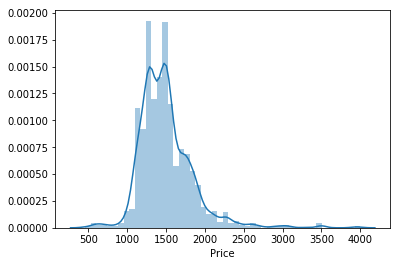

In [226]:
# What do the distribution of rental prices look like?
sns.distplot(dfx.Price)
print("Average rental price in College Park: " + str(dfx.Price.mean()))
print("Max rental price: " + str(dfx.Price.max()))
print("Min rental price: " + str(dfx.Price.min()))

Median rental price/sqft in College Park: 0.5825734549138805


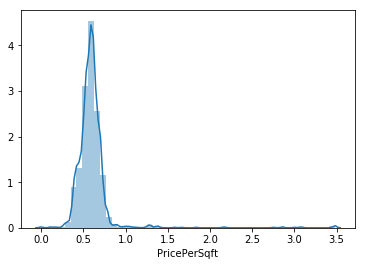

In [227]:
# What about the price/sqft? 
sns.distplot(dfx.PricePerSqft)
print("Median rental price/sqft in College Park: " + str(dfx.PricePerSqft.median()))

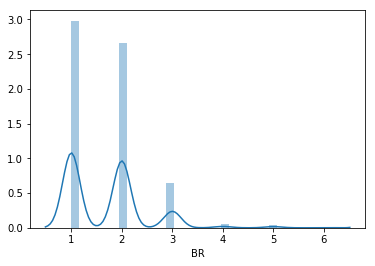

In [228]:
# What about distribution of Bedrooms?
sns.distplot(dfx.BR)

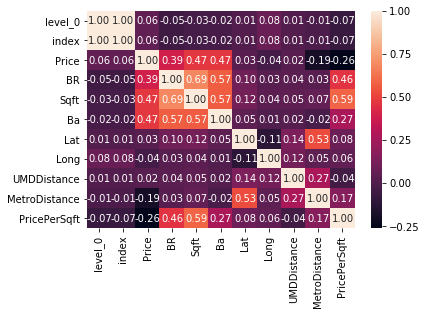

In [229]:
# How correlated are the different features of these rental postings? That is, is price highly correlated with the number
# of bathrooms? We'd expect that being closer to UMD would increase price... Let's look at this through the Pearson
# correlation coefficient map
sns.heatmap(dfx.corr(), annot=True, fmt=".2f")

## Folium: Heatmap of price/sqft
Now, we can use the Folium package to visualize geographically the rental price/sqft in the region. We can see that we don't have as much data as we'd need to make an accurate visualization of this because when we zoom in, it's clear that the data isn't evenly distributed. One trend that appears from this visualization is that the rentals closer to DC appear more expensive. 

In [230]:
# Folium heatmap, where the temperature is the price/sqft
hmdata = []
for index, row in dfx.iterrows():
    hmdata.append([row['Lat'], row['Long'],row['PricePerSqft']])
m = folium.Map(location=[38.9869, -76.9426],tiles='stamentoner', zoom_start=10.9)
HeatMap(hmdata).add_to(m)
m

# PART 5: Price prediction using K-Nearest Neighbors 

## Can we guess what the price of a rental can be given its features? 
Let's do some basic Machine Learning! We'll train our model on a portion of our dataset, and then see how well it can predict the prices of other rentals in the dataset (that the model was **not** trained on), based on their features. Let's first reiterate what our independent variables are and what our dependent variable is. 

**X** = (BR, Sqft, Ba, Lat, Long, UMDDistance, MetroDistance)
**Y** = Price

It is clear why many of the features should be here, but it may not be immediately clear why we still need to keep latitude and longitude in the feature vector, given that we have UMDDistance & MetroDistance. The reason for this is that this encodes the neighborhood of the rental.

### Which ML model should we use?

<img src="machine_learning.png">

All jokes aside, there are a lot of models we could use to predict the price of a rental based on the set of features we have. One of the simplest models to test would be *multi-variate linear regression*, but because our Pearson Correlation Coefficient matrix doesn't show linear correlations for the majority of the 7 independent variables, a linear regression model is probably not best.

Instead, we'll use a **k-nearest neighbors** regressions model.  The way this model works is that when we give a new feature vector, it looks for the k-nearest neighbors (in feature-space) and then takes the average over those k values to  yield a price. 


## K Nearest Neighbors Regression in sklearn

In [231]:
# Basic test case. This is just to see how this works on some test data before we apply it to our dataset
from sklearn.neighbors import KNeighborsRegressor
X = [[1,777], [2,942], [2,850], [2,1110]]
y = [600, 1300, 1100, 1600]
neigh = KNeighborsRegressor(n_neighbors=2)
neigh.fit(X, y) 
KNeighborsRegressor(...)
print(neigh.predict([[1,555]]))


[850.]


In [232]:
# Now, let's import the first 1000 rows as our training data:
neigh = KNeighborsRegressor(n_neighbors=4) # We'll use k=4 as our test case!
X_from_df = dfx2[:1000].as_matrix(columns=['BR','Ba','Sqft','Lat','Long', 'UMDDistance','MetroDistance'])
y = dfx2[:1000].as_matrix(columns=['Price'])
neigh.fit(X_from_df, y) 
KNeighborsRegressor(...)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=Ellipsis, p=2,
          weights='uniform')

In [233]:
# We can predict the price of the 1200th, 1500th and 1800th posting.
print(neigh.predict([dfx2.iloc[1200].as_matrix(columns=['BR','Ba','Sqft','Lat','Long', 'UMDDistance','MetroDistance'])]))
print(neigh.predict([dfx2.iloc[1500].as_matrix(columns=['BR','Ba','Sqft','Lat','Long', 'UMDDistance','MetroDistance'])]))
print(neigh.predict([dfx2.iloc[1800].as_matrix(columns=['BR','Ba','Sqft','Lat','Long', 'UMDDistance','MetroDistance'])]))

[[2617.5]]
[[1100.]]
[[1534.25]]


In [234]:
# And it looks like the actual price is $2595, $1100, $1575 so not so bad. 
print(dfx2.iloc[1200].Price)
print(dfx2.iloc[1500].Price)
print(dfx2.iloc[1800].Price)

2595.0
1100.0
1575.0


We've just barely dipped our feet in the ocean of ML with this example, but I thought it would be nice to try to use our dataset and see how well we can predict prices. Our K-nearest neighbors regression model seems to be predicting the prices quite well!

## Voilà!
That's about all I have time for, I hope you enjoyed this tutorial and that you learned a thing or two! <br> <br>
All the best, <br>
Luc d'Hauthuille